<h3> Script to show the result of the Evaluation metrics </h3>

<p> Here we visualize the effect of the incremental deletion metric. <br> We explain a prediction of ResNet with RISE and delete pixels in the order of relevance given by RISE. <br> from there we measure the confidences and visualize how this deletion influences the model score. </p>

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
from metrics import Incremental_deletion
from pathlib import Path
# keras model and preprocessing tools
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras import utils
# dianna library for explanation
import dianna
from dianna import visualization
# for plotting
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x, verbose=0)

model = Model()

In [3]:
def load_img(path):
    img = utils.load_img(path, target_size=model.input_size)
    x = utils.img_to_array(img)
    x = preprocess_input(x)
    return img, x

def to_img(x):
    z = np.copy(x) 
    z = preprocess_input(z)
    img = utils.array_to_img(z)
    return img

<h5> The image we will be working on <h5>

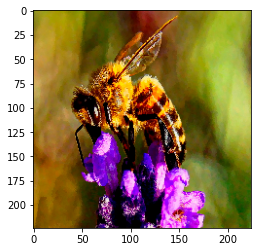

In [4]:
img, x = load_img(Path('.', 'bee.jpg'))
plt.imshow(img)

In [5]:
relevances = dianna.explain_image(model.run_on_batch, x, method="RISE",
                                labels=[i for i in range(1000)],
                                n_masks=1000, feature_res=6, p_keep=.1,
                                axis_labels={2: 'channels'})

Explaining: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


<h5> Visualize the explanation for the predicted label </h5>

1/1 [==============================] - 0s 79ms/step
Explanation for `bee`


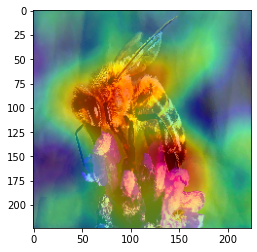

In [6]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

gold_lbl = np.argmax(model.model.predict(x[None, ...]))
expl = relevances[gold_lbl]

print(f'Explanation for `{class_name(gold_lbl)}`')
visualization.plot_image(expl, utils.img_to_array(img) / 255., heatmap_cmap='jet')

In [7]:
def generate_examples(x, inds, impute, nremove=5500):
    '''Helper function to generate examples for removing pixels.
    '''
    imgs = []
    preds = []
    removed = []

    z = np.copy(x)
    for k in range(0, nremove * 5, nremove):
        for i, j in inds[:k]:
            z[i, j, ...] = impute

        pred = np.max(model.model.predict(z[None, ...]), axis=0)[gold_lbl]
        preds.append(pred)
        imgs.append(to_img(z))
        removed.append(k)

    return imgs, preds, removed

In [8]:
inds = np.stack(np.unravel_index(np.argsort(expl, axis=None), expl.shape), axis=1)[::-1] # Get indices after sorting relevances
channel_mean = np.mean(x, axis=(0,1))

_, x = load_img(Path('.', 'bee.jpg'))
imgs, preds, nremoved = generate_examples(x, inds, channel_mean)

# Remove at random
_, x = load_img(Path('.', 'bee.jpg'))
np.random.shuffle(inds)
rand_imgs, rand_preds, nremoved = generate_examples(x, inds, channel_mean)

1/1 [==============================] - 0s 77ms/step


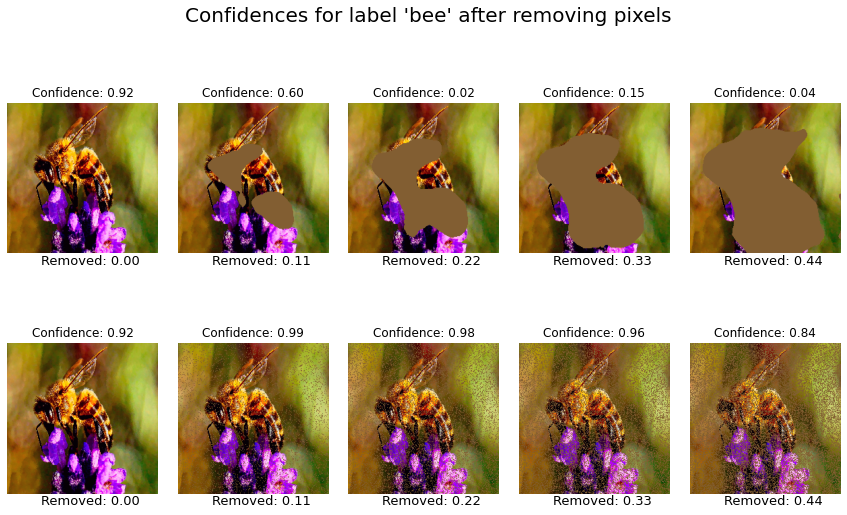

In [9]:
# Visualize the examples
npixels = x.shape[0] * x.shape[1]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

for i, (img, rand_img, removed) in enumerate(zip(imgs, rand_imgs, nremoved)):
    col = axes[:,i]

    for a in col:
        a.text(50, 240, 'Removed: {:.2f}'.format(removed / npixels), fontsize=13)
        a.axis('off')

    col[0].set_title("Confidence: {:.2f}".format(preds[i]))
    col[0].imshow(img)
    col[1].set_title("Confidence: {:.2f}".format(rand_preds[i]))
    col[1].imshow(rand_img)

fig.suptitle("Confidences for label 'bee' after removing pixels", size=20)
fig.tight_layout()
plt.show()

We now introduce our metric `Incremental_deletion` and call its visualize method to show the correctness of the explantion.

Evaluating: 100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


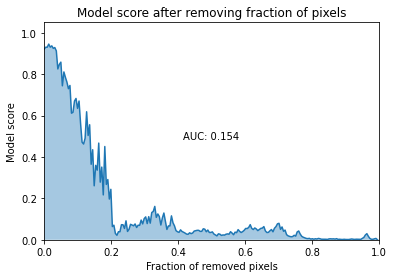

In [11]:
deleter = Incremental_deletion(model.model.predict, 224)

scores = deleter.evaluate(x, expl, batch_size=10, verbose=0)
deleter.visualize(scores)